# Loading data, merging & preparation

In [ ]:
#importing all libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("whitegrid")
import scipy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import time
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Creating Initial Datasets - files uploaded to Google Collab

holidays = pd.read_csv('gdrive/My Drive/holidays_events.csv')
oil = pd.read_csv('gdrive/My Drive/oil.csv')
train = pd.read_csv('gdrive/My Drive/train.csv')
test = pd.read_csv('gdrive/My Drive/test.csv') 
transactions = pd.read_csv('gdrive/My Drive/transactions.csv') 
stores = pd.read_csv('gdrive/My Drive/stores.csv')

#Making 4 dataframes - Test and Train with sales by Product Family, and Test and Train with Sales/Transactions by Store Number

In [ ]:
#Investigation Train Dataset
train.head() #5 Columns (ID, Date, Store Number, Product Family, Sales (Sales within Product Family), OnPromotion 
#(Total Number of Items in Product Family being promoted at given date))

#Making ID Column index
train = train.set_index('id')

train.info() #Date column is object - changing to datetime & Dataset has no null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB


In [ ]:
#Converting Date Object Column to Datetime
train["date"] = pd.to_datetime(train["date"])

#Removing rows that are before 2013 - our analysis is looking at Jan 2013 data onwards
train = train[train['date'].dt.year >= 2013]

#Confirming dates
train = train.sort_values('date', axis=0, ascending=True, inplace=False) #Now starts at Jan 2013
train

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1194,2013-01-01,42,CELEBRATION,0.000,0
1193,2013-01-01,42,BREAD/BAKERY,0.000,0
1192,2013-01-01,42,BOOKS,0.000,0
1191,2013-01-01,42,BEVERAGES,0.000,0
...,...,...,...,...,...
2999693,2017-08-15,25,PET SUPPLIES,3.000,0
2999692,2017-08-15,25,PERSONAL CARE,93.000,8
2999691,2017-08-15,25,MEATS,180.107,0


In [ ]:
#Investigation Test Dataset
#IMPORTANT NOTE: Testing data provided doesn't include transaction or sales,
# therefore in order to get metrics on how accurate the model is we will still need 
#to split the training data into train/test datasets. The testing data 
#provided by the Kaggle competition is purely for prediction and not to test model accuracy. 

test.head() #5 Columns (Same as Train) 
test.info() #No Null values 

test = test.set_index('id')

#Converting Date Object Column to Datetime
test["date"] = pd.to_datetime(test["date"])

#Seeing dates for the test set
test = test.sort_values('date', axis=0, ascending=True, inplace=False) 
#Testing data is the next 15 days after the Training data - this will allow us to predict the next 15 days based on the



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [ ]:
test.date.unique() #last 15days of August 2017

array(['2017-08-16T00:00:00.000000000', '2017-08-17T00:00:00.000000000',
       '2017-08-18T00:00:00.000000000', '2017-08-19T00:00:00.000000000',
       '2017-08-20T00:00:00.000000000', '2017-08-21T00:00:00.000000000',
       '2017-08-22T00:00:00.000000000', '2017-08-23T00:00:00.000000000',
       '2017-08-24T00:00:00.000000000', '2017-08-25T00:00:00.000000000',
       '2017-08-26T00:00:00.000000000', '2017-08-27T00:00:00.000000000',
       '2017-08-28T00:00:00.000000000', '2017-08-29T00:00:00.000000000',
       '2017-08-30T00:00:00.000000000', '2017-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [ ]:
#Merging columns to Train Dataset - 3,000,888 rows (Store Information)

stores.head()

#Can combine columns to Train based on Store Number - putting in filter to confirm if store has duplicate values based on store_nbr
train = train.merge(stores,how='left',on='store_nbr', validate = 'm:1')

#No duplicate vales - many (train) to one (stores) merge

train 


,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13
1,2013-01-01,42,CELEBRATION,0.000,0,Cuenca,Azuay,D,2
2,2013-01-01,42,BREAD/BAKERY,0.000,0,Cuenca,Azuay,D,2
3,2013-01-01,42,BOOKS,0.000,0,Cuenca,Azuay,D,2
4,2013-01-01,42,BEVERAGES,0.000,0,Cuenca,Azuay,D,2
...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,25,PET SUPPLIES,3.000,0,Salinas,Santa Elena,D,1
3000884,2017-08-15,25,PERSONAL CARE,93.000,8,Salinas,Santa Elena,D,1
3000885,2017-08-15,25,MEATS,180.107,0,Salinas,Santa Elena,D,1
3000886,2017-08-15,26,BEAUTY,0.000,0,Guayaquil,Guayas,D,10


In [ ]:
#Merging columns to Train Dataset - 3,000,888 rows (Oil Prices by Date)

oil.head()
#Updating Date column to Datetime
oil["date"] = pd.to_datetime(oil["date"])
oil = oil.set_index('date')
oil = oil.sort_values('date', axis=0, ascending=True, inplace=False) 

#Seeing how many NA values there are
oil.isnull().sum(axis = 0) #43 values - since this is only 4% of the total oil data I will be imputing values based on an autocorrelation study (see if the oil prices are correlated to each other).

dcoilwtico    43
dtype: int64

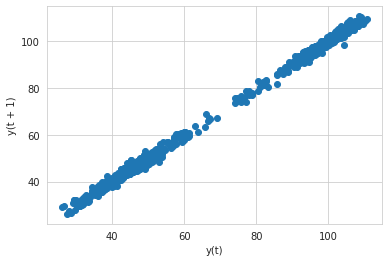

In [ ]:
#Checking to see if oil prices have auto correlation or are correlated to each other
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

pd.plotting.lag_plot(oil, lag=1) #lag by each instance

#Based on the below visualization, oil price suggests a positive autocorrelated pattern by each instance/row.  
#Because of this, will be using backfill to fill in the missing values within oil prices (i.e. tomorrows's oil price will be put as today's.).

In [ ]:
#Backfilling Oil Prices based on previous day
oil = oil.fillna(method='bfill')
oil.isnull().sum(axis = 0)

dcoilwtico    0
dtype: int64

In [ ]:
#Merging Oil
train = train.merge(oil, how = 'left', on='date', validate = 'm:1')

#Backfilling Oil Prices again
train = train.fillna(method = 'bfill')
train.isnull().sum(axis = 0)
train

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,93.14
1,2013-01-01,42,CELEBRATION,0.000,0,Cuenca,Azuay,D,2,93.14
2,2013-01-01,42,BREAD/BAKERY,0.000,0,Cuenca,Azuay,D,2,93.14
3,2013-01-01,42,BOOKS,0.000,0,Cuenca,Azuay,D,2,93.14
4,2013-01-01,42,BEVERAGES,0.000,0,Cuenca,Azuay,D,2,93.14
...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,25,PET SUPPLIES,3.000,0,Salinas,Santa Elena,D,1,47.57
3000884,2017-08-15,25,PERSONAL CARE,93.000,8,Salinas,Santa Elena,D,1,47.57
3000885,2017-08-15,25,MEATS,180.107,0,Salinas,Santa Elena,D,1,47.57
3000886,2017-08-15,26,BEAUTY,0.000,0,Guayaquil,Guayas,D,10,47.57


In [ ]:
#Merging columns to Train Dataset - 3,000,888 rows 

#Notes on Holidays
#Transferred = Column dictactes if a holiday was transferred to a different day. Transferred = True is not a holiday
#Type = Holiday, Transfer (shows if a holiday was transferred to this date), Additional (additional day),
# Bridge (Extra days added onto work)
#Work Day (day not usually scheduled, but is scheduled to pay back for the Bridge day), Event (no metadata but look to be national holidays) 
#Local  = City Based Holiday, Regional = State wide holiday, and national = national holiday whole country 

#Merging Holiday to Train Dataset
holidays.head() 
holidays["date"] = pd.to_datetime(holidays["date"])
holidays = holidays[(holidays['date'].dt.year >= 2013)]
holidays = holidays.rename(columns = {'type':'Holiday'})

#Transferred Holidays - according to metadata these are not holidays as the holiday has been transferred to different day
holidays = holidays.drop(holidays[(holidays['transferred'] == "True")].index)
holidays = holidays.drop(holidays[(holidays['Holiday'] == "Work Day")].index) 
holidays.drop('transferred', axis=1, inplace=True)

#Renaming Additional and Bridge to "Holiday" in Type Column
holidays = holidays.replace({'Holiday':{'Additional' : 'Holiday', 'Bridge' : 'Holiday', 'Event' : 'Holiday' ,
                                        'Event' : 'Holiday', 'Transfer': 'Holiday'}})  

#Creating New Dataframes for Local, Regional, and National Holidays 
regional = holidays[holidays.locale == "Regional"].rename({"Holiday":"Regional Holiday", "locale_name":"state"}, axis = 1).drop(["locale", "description"], axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"Holiday":"National Holiday"}, axis = 1).drop(["locale", "locale_name", "description"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"Holiday":"Local Holiday", "locale_name":"city"}, axis = 1).drop(["locale", "description"], axis = 1).drop_duplicates()


#Confirming
local

,date,Local Holiday,city
46,2013-03-02,Holiday,Manta
48,2013-04-12,Holiday,Cuenca
49,2013-04-14,Holiday,Libertad
50,2013-04-21,Holiday,Riobamba
54,2013-05-12,Holiday,Puyo
...,...,...,...
339,2017-12-05,Holiday,Quito
340,2017-12-06,Holiday,Quito
341,2017-12-08,Holiday,Loja
342,2017-12-08,Holiday,Quito


In [ ]:
train = train.merge(national, how = "left", on="date", validate = 'm:1') 
# Regional
train = train.merge(regional, how = "left", on=["date", "state"], validate = 'm:1') 
# Local
train = train.merge(local, how = "left", on = ["date", "city"],validate = 'm:1')

In [ ]:
train = train.sort_values('date', axis=0, ascending=True, inplace=False) 
train

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,National Holiday,Regional Holiday,Local Holiday
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,93.14,Holiday,NaN,NaN
1194,2013-01-01,33,SEAFOOD,0.000,0,Quevedo,Los Rios,C,3,93.14,Holiday,NaN,NaN
1193,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,93.14,Holiday,NaN,NaN
1192,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,93.14,Holiday,NaN,NaN
1191,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,93.14,Holiday,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999693,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0,Quito,Pichincha,B,6,47.57,NaN,NaN,NaN
2999692,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,NaN,NaN,NaN
2999691,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,NaN,NaN,NaN
2999702,2017-08-15,9,LADIESWEAR,10.000,0,Quito,Pichincha,B,6,47.57,NaN,NaN,NaN


In [ ]:
#Finally filling in all Nan Holiday values with 0 and Holiday to 1 for future One Hot Encoding
train['National Holiday'] = train['National Holiday'].fillna(0)
train['Regional Holiday'] = train['Regional Holiday'].fillna(0)
train['Local Holiday'] = train['Local Holiday'].fillna(0)

train['National Holiday'] = np.where(train['National Holiday'] == "Holiday", 1, train['National Holiday'])
train['Regional Holiday'] = np.where(train['Regional Holiday'] == "Holiday", 1, train['Regional Holiday'])
train['Local Holiday'] = np.where(train['Local Holiday'] == "Holiday", 1, train['Local Holiday'])


In [ ]:
#Merging all Items to Testing Data = (28,512 rows)

#Store 
test = test.merge(stores,how='left',on='store_nbr', validate = 'm:1')

#Oil 
test = test.merge(oil, how = 'left', on='date', validate = 'm:1')

#Backfilling Oil Prices again
test = test.fillna(method = 'bfill')

#Holidays
test = test.merge(national, how = "left", on="date", validate = 'm:1') 
# Regional
test = test.merge(regional, how = "left", on=["date", "state"], validate = 'm:1') 
# Local
test = test.merge(local, how = "left", on = ["date", "city"],validate = 'm:1')

test.isnull().sum(axis = 0)

#Finally filling in all Nan Holiday values with 0 and Holiday to 1 for future One Hot Encoding
test['National Holiday'] = test['National Holiday'].fillna(0)
test['Regional Holiday'] = test['Regional Holiday'].fillna(0)
test['Local Holiday'] = test['Local Holiday'].fillna(0)

test['National Holiday'] = np.where(test['National Holiday'] == "Holiday", 1, test['National Holiday'])
test['Regional Holiday'] = np.where(test['Regional Holiday'] == "Holiday", 1, test['Regional Holiday'])
test['Local Holiday'] = np.where(test['Local Holiday'] == "Holiday", 1, test['Local Holiday'])

test

,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,National Holiday,Regional Holiday,Local Holiday
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,0,0,0
1,2017-08-16,42,CELEBRATION,0,Cuenca,Azuay,D,2,46.80,0,0,0
2,2017-08-16,42,BREAD/BAKERY,12,Cuenca,Azuay,D,2,46.80,0,0,0
3,2017-08-16,42,BOOKS,0,Cuenca,Azuay,D,2,46.80,0,0,0
4,2017-08-16,42,BEVERAGES,19,Cuenca,Azuay,D,2,46.80,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,25,PET SUPPLIES,0,Salinas,Santa Elena,D,1,47.26,0,0,0
28508,2017-08-31,25,PERSONAL CARE,6,Salinas,Santa Elena,D,1,47.26,0,0,0
28509,2017-08-31,25,MEATS,1,Salinas,Santa Elena,D,1,47.26,0,0,0
28510,2017-08-31,26,BEAUTY,1,Guayaquil,Guayas,D,10,47.26,0,0,0


In [ ]:
print(train.head(2))

           date  store_nbr      family  sales  onpromotion     city      state type  cluster  dcoilwtico National Holiday Regional Holiday Local Holiday
0    2013-01-01          1  AUTOMOTIVE    0.0            0    Quito  Pichincha    D       13       93.14                1                0             0
1194 2013-01-01         33     SEAFOOD    0.0            0  Quevedo   Los Rios    C        3       93.14                1                0             0


In [ ]:
print(test.head(2))

        date  store_nbr       family  onpromotion    city      state type  cluster  dcoilwtico  National Holiday  Regional Holiday Local Holiday
0 2017-08-16          1   AUTOMOTIVE            0   Quito  Pichincha    D       13        46.8                 0                 0             0
1 2017-08-16         42  CELEBRATION            0  Cuenca      Azuay    D        2        46.8                 0                 0             0


# <font color='blue'>Gradient boosting using XGBoost Regressor</font>

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#<font color='blue'>Data Analysis and Preparation</font>

In [ ]:
df=train.copy()

In [ ]:
df=df.set_index('date')
df.head(2)

,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,National Holiday,Regional Holiday,Local Holiday
date,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,1,0,0
2013-01-01,33,SEAFOOD,0.0,0,Quevedo,Los Rios,C,3,93.14,1,0,0


In [ ]:
#checking how sales and onpromotions are on different stores separating it family wise
te=df.groupby(['store_nbr','family'])[['onpromotion','sales']].sum()
te

onpromotion         sales
store_nbr family                                               
1         AUTOMOTIVE                           14  5.475000e+03
          BABY CARE                             0  0.000000e+00
          BEAUTY                              226  4.056000e+03
          BEVERAGES                         15864  2.673769e+06
          BOOKS                                 0  2.110000e+02
...                                           ...           ...
54        POULTRY                            1509  8.888981e+04
          PREPARED FOODS                      700  1.030900e+05
          PRODUCE                            9070  5.961803e+05
          SCHOOL AND OFFICE SUPPLIES          277  1.023000e+03
          SEAFOOD                             185  2.938000e+03

[1782 rows x 2 columns]

In [ ]:
fig = px.scatter(te, x=te.index.get_level_values('store_nbr'), y="onpromotion",
                 color=te.index.get_level_values('family'),size='sales',
                  labels={
                     "x": "Stores",
                     "color": "Product Family"},
                 title='Product family wise plot for sales VS onpromotions on different stores')
fig.show()

Since the majority of the sales contribution in all stores is by the categories; 'grocery I', 'produce','cleaning','dairy','beverages', so for the rest of the categories, we can club them as 'others'

In [ ]:
#checking how sales and onpromotions are on different store types and store clusters
ty=df.groupby(['type','cluster'])[['onpromotion','sales']].sum()
fig = px.scatter(ty, x=ty.index.get_level_values('type'), y="sales", 
                 color=ty.index.get_level_values('cluster'),size='onpromotion',
                labels={
                     "x": "Store types",
                     "color": "Clusters"},
                 title='Store cluster wise plot for store type VS sales<br> using different promotions as the size of each point'
                 )
fig.show()


Store types A, B & C have put the most items on promotions. And generally stores in cluster 6 and  cluster 14 made the most sales.Lets see if we can find stores specific to areas or cities making a significant contribution to sales

In [ ]:
#checking if store numbers of different types in different states have any correlation to sales
city_area_wise=df.groupby(['state','type','cluster'])[['sales']].sum()
fig = px.scatter(city_area_wise, x=city_area_wise.index.get_level_values('cluster'), y=city_area_wise.index.get_level_values('state'),
                 color=city_area_wise.index.get_level_values('type'),size='sales',
                  labels={
                     "x": "Stores arranged in clusters",
                     'y':'States',
                     "color": "type"},
                 title='Store cluster wise plot for store type VS States showing respective sales as the size of each point'
                 )
fig.show()

The major two cities who seem to be contributing most in sales is Pichincha and Guayas, however it doesnt seem area is a significant contributor towards sales. Type of the store seems to be more promising feature in terms of its contribution to sales. So we can safely drop city, state, store_nbr and cluster as our categorical variables. 

In [ ]:
# checking which holidays have an impact on sales.
NH=df.groupby('National Holiday').agg(total_sale=('sales','sum'))
NH['Percentage_ratio']=(NH['total_sale']/NH['total_sale'].sum())*100
NH

,total_sale,Percentage_ratio
National Holiday,,
0,9.718255e+08,90.516469
1,1.018194e+08,9.483531


In [ ]:
RH=df.groupby('Regional Holiday').agg(total_sale=('sales','sum'))
RH['Percentage_ratio']=(RH['total_sale']/RH['total_sale'].sum())*100
RH

,total_sale,Percentage_ratio
Regional Holiday,,
0,1.073410e+09,99.978111
1,2.350091e+05,0.021889


In [ ]:
LH=df.groupby('Local Holiday').agg(total_sale=('sales','sum'))
LH['Percentage_ratio']=(LH['total_sale']/LH['total_sale'].sum())*100
LH

,total_sale,Percentage_ratio
Local Holiday,,
0,1.068442e+09,99.515435
1,5.202511e+06,0.484565


From the above analysis, Only National Holidays had some impact on the sales. And its only 10%. Based on this we will only include National Holiday as our categorical variable

In [ ]:
df=df.rename(columns={'dcoilwtico':'oil price'})# renaming oil columns
df[['onpromotion','sales','oil price']].describe()

,onpromotion,sales,oil price
count,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.602770e+00,3.577757e+02,6.786216e+01
std,1.221888e+01,1.101998e+03,2.570423e+01
min,0.000000e+00,0.000000e+00,2.619000e+01
25%,0.000000e+00,0.000000e+00,4.632000e+01
50%,0.000000e+00,1.100000e+01,5.319000e+01
75%,0.000000e+00,1.958473e+02,9.580250e+01
max,7.410000e+02,1.247170e+05,1.106200e+02


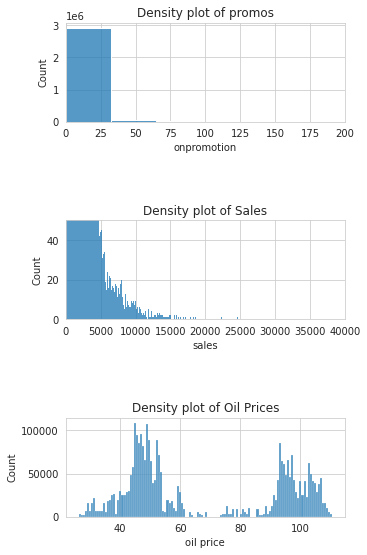

In [ ]:
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(5,7))
p1=sns.histplot(df['onpromotion'],ax=ax[0])
p1.set(xlim=(0,200))
ax[0].set_title('Density plot of promos')

p2=sns.histplot(df['sales'],ax=ax[1])
p2.set(xlim=(0,40000))
p2.set(ylim=(0,50))
ax[1].set_title('Density plot of Sales')

p3=sns.histplot(df['oil price'],ax=ax[2])
ax[2].set_title('Density plot of Oil Prices')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1, wspace=0.4);

The Data distribution for promos and sales is skewed towards extreme right. Also the distribution of oil prices is bimodal, which is mainly due to the recession period. In such scenarios, its best to exclude the pre-recession times, as it would disturb the ML model learning. However before that its important to visualise the data on daily time series.

In [ ]:
#finding daily total sales and oil prices
oil_tmp=df.resample('D').last()[['oil price']]
total_sales=df.resample('D')[['sales']].apply(lambda x: round(x.sum(),2))


In [ ]:
# plotting daily oil prices
fig = px.line(oil_tmp, x=oil_tmp.index, y='oil price', title='Oil prices from 2013-2017')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()
# plotting daily total sales
fig2 = px.line(total_sales, x=total_sales.index, y='sales', title='Daily total sales from 2013-2017')
fig2.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig2.show()

Its interesting to see how sales are actually more when oil prices drop. Lets see how promotions behaved with respect to time.

In [ ]:
total_promo=df.resample('D')[['onpromotion']].apply(lambda x: round(x.sum(),2))
# plotting daily promotions
fig = px.line(total_promo, x=total_promo.index, y='onpromotion', title='Daily Total Promotions from 2013-2017')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

If you expand the trend monthly or weekly basis, you see that promotions started in the midst of summers 2014. July 2014-Jan2015, we see how oil prices had a major decrease, and then from July2015 onwards, we see a much rise in promotion of item numbers. also it seems to follow a seasonality where number of items on promotion rises atleast twice in mid weeks. Hence contributed towards more sales.

The initial drop in oil prices from mid-2014 to early 2015 was primarily due to supply factors. Demands were high but supply wasnt able to meet the needs due to booming U.S. oil production, receding geopolitical concerns, and shift of OPEC policies. This was the largest oil price declines in modern history faced globally for all economies. However by 2016, the oil prices started stabilising again, ofcourse not to the levels of 2014 but stabilising. Lets see if we find any significant correlation between sales, oil prices and promotions. 

In [ ]:
df[['onpromotion','sales','oil price']].corr()

,onpromotion,sales,oil price
onpromotion,1.000000,0.427923,-0.154265
sales,0.427923,1.000000,-0.075036
oil price,-0.154265,-0.075036,1.000000


The linear correlations seem weak, however it would be interesting to see if excluding the period of oil recsession, creates some impact. So selecting period from Jan, 2016 onwards.

In [ ]:
df_2016=df.loc['2016-01-01':,:]
df_2016[['onpromotion','sales','oil price']].corr()

,onpromotion,sales,oil price
onpromotion,1.000000,0.550590,0.071998
sales,0.550590,1.000000,0.011591
oil price,0.071998,0.011591,1.000000


Linear correlation of sales and promotions definitely improves however there is very weak relationship of oil prices and sales, apart from this that correlation becomes positive. In terms of predicting sales, a linear regression will not be suitable, however we can try to predict using decision trees as they are immune to correlations.

In [ ]:
#family values that seemed to have high contribution in sales
family_values=['GROCERY I', 'PRODUCE','CLEANING','DAIRY','BEVERAGES','DELI']

In [ ]:
# imputing other values as 'OTHERS'
df.loc[~df['family'].isin(family_values),'family']='OTHERS'

In [ ]:
df.family.unique()

array(['OTHERS', 'BEVERAGES', 'CLEANING', 'DAIRY', 'DELI', 'GROCERY I',
       'PRODUCE'], dtype=object)

In [ ]:
df_new=df.copy()

In [ ]:
df_new.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type',
       'cluster', 'oil price', 'National Holiday', 'Regional Holiday',
       'Local Holiday'],
      dtype='object')

In [ ]:
#Extracting data from 2016 onwards.
df_new=df_new.loc['2016-01-01':,['family','type','onpromotion','National Holiday','oil price','sales']]
df_new.reset_index()

,date,family,type,onpromotion,National Holiday,oil price,sales
0,2016-01-01,CLEANING,D,0,1,36.81,0.000
1,2016-01-01,OTHERS,D,0,1,36.81,0.000
2,2016-01-01,OTHERS,D,0,1,36.81,0.000
3,2016-01-01,OTHERS,D,0,1,36.81,0.000
4,2016-01-01,OTHERS,D,0,1,36.81,0.000
...,...,...,...,...,...,...,...
1054939,2017-08-15,OTHERS,B,0,0,47.57,6.000
1054940,2017-08-15,OTHERS,B,0,0,47.57,438.133
1054941,2017-08-15,OTHERS,B,1,0,47.57,154.553
1054942,2017-08-15,OTHERS,B,0,0,47.57,10.000


In [ ]:
# aggregating data with respect to date, family and type
df1=df_new.groupby(['date','National Holiday','family','type'], as_index=False).agg(total_sale=('sales','sum'),
                                                                 promo=('onpromotion','sum'),
                                                                 oil_price=('oil price','min'))
df1

,National Holiday,family,type,total_sale,promo,oil_price
0,1,BEVERAGES,A,0.000,0,36.81
1,1,BEVERAGES,B,0.000,0,36.81
2,1,BEVERAGES,C,0.000,0,36.81
3,1,BEVERAGES,D,5104.000,1,36.81
4,1,BEVERAGES,E,0.000,0,36.81
...,...,...,...,...,...,...
20715,0,PRODUCE,A,38131.831,82,47.57
20716,0,PRODUCE,B,17984.812,1082,47.57
20717,0,PRODUCE,C,14765.070,1319,47.57
20718,0,PRODUCE,D,43730.397,122,47.57


In [ ]:
df1.describe()

,National Holiday,total_sale,promo,oil_price
count,20720.000000,20720.000000,20720.000000,20720.000000
mean,0.106419,23304.613481,302.327847,45.557686
std,0.308380,22441.524613,401.412606,6.424027
min,0.000000,0.000000,0.000000,26.190000
25%,0.000000,5852.500000,51.000000,43.340000
50%,0.000000,15173.289500,168.000000,46.830000
75%,0.000000,36596.500000,421.000000,49.760000
max,1.000000,195726.000000,3645.000000,54.480000


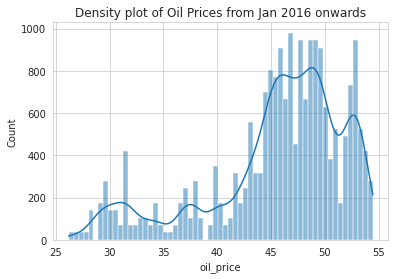

In [ ]:
#checking if removing the pre recession period, improved the bi modal distribution of oil prices
g=sns.histplot(df1['oil_price'],kde=True)
g.set_title('Density plot of Oil Prices from Jan 2016 onwards');


#<font color='blue'>Creating Pipeline</font>

In [ ]:
categorical_vars=['family','type','National Holiday']
discrete_vars=['promo']
continous_vars=['oil_price']
target=['total_sale']

In [ ]:
X=df1[categorical_vars+discrete_vars+continous_vars]
y=df1[target]

In [ ]:
#shuffling the data, as data was arranged in the sequence of time, so ensuring the test/train split doesnt carry any bias
from sklearn.utils import shuffle
X = shuffle(X, random_state=0)
y= shuffle(y, random_state=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (16576, 5)
X_test.shape: (4144, 5)
y_train.shape: (16576, 1)
y_test.shape: (4144, 1)


In [ ]:
#creating preprocessors for applying standard scalar transformations on continous & discrete variables
# and also doing one-hot encoding of the categorical varaibles
preprocessor = make_column_transformer(
    (StandardScaler(),continous_vars+discrete_vars),
    (OneHotEncoder(), categorical_vars))

In [ ]:
#creating a full pipeline
pipe_full=Pipeline([('cat_dis',preprocessor)])
pipe_full

Pipeline(steps=[('cat_dis',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['oil_price', 'promo']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['family', 'type',
                                                   'National Holiday'])]))])

In [ ]:
#applying pipeline on X_train and X_test
pipe_full.fit(X_train,y_train)
X_train_transformed = pipe_full.transform(X_train)
X_test_transformed = pipe_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (16576, 16)
X_test_transformed.shape: (4144, 16)


In [ ]:
total_cat_vars=pipe_full.named_steps['cat_dis'].named_transformers_['onehotencoder'].get_feature_names_out(categorical_vars)
print(f'Total Categorical vars: {len(total_cat_vars)}')
print(total_cat_vars)

Total Categorical vars: 14
['family_BEVERAGES' 'family_CLEANING' 'family_DAIRY' 'family_DELI'
 'family_GROCERY I' 'family_OTHERS' 'family_PRODUCE' 'type_A' 'type_B'
 'type_C' 'type_D' 'type_E' 'National Holiday_0' 'National Holiday_1']


In [ ]:
total_num_vars=pipe_full.named_steps['cat_dis'].named_transformers_['standardscaler'].get_feature_names_out(continous_vars+discrete_vars)
print(f'Total numerical vars: {len(total_num_vars)}')
print(total_num_vars)

Total numerical vars: 2
['oil_price' 'promo']


In [ ]:
#names of all the features which will be used in the XGBoost model
all_features=total_num_vars.tolist()+total_cat_vars.tolist()
all_features

['oil_price',
 'promo',
 'family_BEVERAGES',
 'family_CLEANING',
 'family_DAIRY',
 'family_DELI',
 'family_GROCERY I',
 'family_OTHERS',
 'family_PRODUCE',
 'type_A',
 'type_B',
 'type_C',
 'type_D',
 'type_E',
 'National Holiday_0',
 'National Holiday_1']

#<font color='blue'>XGBoost Regressor with Hyperparameter tunning and Cross validation checks for model performance</font>

In [ ]:
#Preparing grid parameters for hyper parameter tuning using GridSearchcv
gbes = XGBRegressor()
param_grid = {"max_depth":    [2, 5,10],
              "n_estimators": [100,500],
              "learning_rate": [0.02,0.05,0.7,0.3],
              'objective':['reg:squarederror'],
              'min_child_weight': [4,6,10],
               'colsample_bytree': [0.3, 0.7],
              'eval_metric': ['rmse']}
model_xg = GridSearchCV(gbes, param_grid, cv=5)

In [ ]:
model_xg.fit(X_train_transformed, np.ravel(y_train))

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'eval_metric': ['rmse'],
                         'learning_rate': [0.02, 0.05, 0.7, 0.3],
                         'max_depth': [2, 5, 10],
                         'min_child_weight': [4, 6, 10],
                         'n_estimators': [100, 500],
                         'objective': ['reg:squarederror']})

In [ ]:
#Checking train - test scores of the best estimated model by GridSearchcv
print(f'Accuracy of X_trained: {model_xg.score(X_train_transformed,np.ravel(y_train))}')
print(f'Accuracy of X_test: {model_xg.score(X_test_transformed,np.ravel(y_test))}')

Accuracy of X_trained: 0.9558986992994947
Accuracy of X_test: 0.9250038289375022


In [ ]:
#the best estimator by the GridSearchcv
model_xg.best_estimator_

XGBRegressor(colsample_bytree=0.7, eval_metric='rmse', learning_rate=0.3,
             max_depth=5, min_child_weight=10, n_estimators=500,
             objective='reg:squarederror')

To validate, the efficieny of these tunned parameter, we can try to use the builtin API for cross validation of XGBoost and see if the same model accuracy can be achieved.

In [ ]:
#Initialising the Dmatrix with X_train_transformed and X_test_transformed
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_transformed, label=np.ravel(y_train),
                     feature_names=all_features)
dtest = xgb.DMatrix(X_test_transformed, label=np.ravel(y_test),
                    feature_names=all_features)

In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth':5,
    'min_child_weight': 10,
    'eta':0.3,
    'objective':'reg:squarederror',
    'colsample_bytree': 0.7,
    'n_estimators':500,
    'eval_metric': ['rmse']
}

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:24080.3
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:18597.9
[2]	Test-rmse:14729.9
[3]	Test-rmse:12446.2
[4]	Test-rmse:11152.6
[5]	Test-rmse:9797.27
[6]	Test-rmse:9098.33
[7]	Test-rmse:8484.51
[8]	Test-rmse:8111.06
[9]	Test-rmse:7954.95
[10]	Test-rmse:7783.38
[11]	Test-rmse:7703.08
[12]	Test-rmse:7630.41
[13]	Test-rmse:7581.54
[14]	Test-rmse:7551.71
[15]	Test-rmse:7525.81
[16]	Test-rmse:7508.19
[17]	Test-rmse:7398.25
[18]	Test-rmse:7269.39
[19]	Test-rmse:7211.02
[20]	Test-rmse:7198.35
[21]	Test-rmse:7190.55
[22]	Test-rmse:7177.46
[23]	Test-rmse:7161.88
[24]	Test-rmse:7110.61
[25]	Test-rmse:7074.84
[26]	Test-rmse:7020
[27]	Test-rmse:6972.45
[28]	Test-rmse:6959.21
[29]	Test-rmse:6948.4
[30]	Test-rmse:6877.89
[31]	Test-rmse:6835.52
[32]	Test-rmse:6834.07
[33]	Test-rmse:6831.83
[34]	Test-rmse:6793.34
[35]	Test-rmse:6787.94
[36]	Test-rmse:6767.13
[37]	Test-rmse:6757.75
[38]	Test-rmse:6754.77
[39]	Test-rmse:6710.92
[40]	Test-rmse:6678.94
[41]	Test-rmse

In [ ]:
print("Best Test RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best Test RMSE: 6035.70 with 267 rounds


In [ ]:
#checking the built in function of XGBoost Regressor, which shows the result summary of mean train-rmse and test-rmse
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=999,
    seed=42,
    nfold=5,
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,24751.671484,133.640758,24747.869141,623.595388
1,19405.516406,270.335356,19456.876172,655.096177
2,15702.627539,359.477801,15777.273047,626.537373
3,13047.917187,332.532440,13142.261914,647.535408
4,11297.546484,222.369787,11411.459180,446.975245
...,...,...,...,...
301,5042.601367,68.861117,6730.362012,337.819568
302,5040.265820,69.342585,6730.397949,336.950019
303,5037.544141,70.285420,6728.415918,334.162998
304,5035.036914,69.586781,6728.588770,334.757964


In [ ]:
#checking if best estimator of GridSearchcv also resulted in the similar rmse.
y_predict = model_xg.best_estimator_.predict(X_test_transformed) 
print('Test accuracy for XG boost regressor as RMSE:')
print(round(np.sqrt(mean_squared_error(y_predict,y_test)),2))

Test accuracy for XG boost regressor as RMSE:
6016.24


Its pretty close, rather better through GridSearchcv, so for model prediction and evaluation, we will be using the best_estimator of GridSearchcv

In [ ]:
#checking the basic stats of y_predict and y_test
print('Y_predict - mean:',np.mean(y_predict))
print('Y_predict - std_dev:',np.std(y_predict))
y_test.describe()

Y_predict - mean: 23174.5
Y_predict - std_dev: 21355.467


,total_sale
count,4144.000000
mean,22982.934885
std,21971.428467
min,0.000000
25%,5679.641250
50%,15146.379002
75%,36398.195500
max,158367.000000


Just by looking at the distribution stats, we can see the xgboost regressor, gave very good prediction of the target variable. RMSE values are very much in the std deviation intervals.

In [ ]:
#checking for R2 and Adjusted R2
from sklearn.metrics import r2_score
r_squared = r2_score(y_test,y_predict)
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test_transformed.shape[1]-1)
print('R2 - ',r_squared)
print('Adjusted R2 - ',adjusted_r_squared)

R2 -  0.9250038289375022
Adjusted R2 -  0.924713075669511


R2 and Adjusted R2 of the y_predict also shows, the XGBoost Regressor's success.

# <font color='blue'>Learning Curves<font>

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
  fig, axes = plt.subplots(1, 2, figsize=(10,4))
  

  axes[0].set_title(title)
  if ylim is not None:
      axes[0].set_ylim(*ylim)
      axes[0].set_xlabel("Training examples")
      axes[0].set_ylabel("Score")

  train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  fit_times_mean = np.mean(fit_times, axis=1)
  fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
  axes[0].grid()
  axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
  axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
  axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
  axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
  axes[0].legend(loc="best")
  axes[0].set(xlim=(0,14000))
  fig.subplots_adjust(wspace=0.3)

  # Plot fit_time vs score
  fit_time_argsort = fit_times_mean.argsort()
  fit_time_sorted = fit_times_mean[fit_time_argsort]
  test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
  test_scores_std_sorted = test_scores_std[fit_time_argsort]
  axes[1].grid()
  axes[1].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
  axes[1].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1)
  axes[1].set_xlabel("fit_times")
  axes[1].set_ylabel("Score")
  axes[1].set_title("Performance of the model")
  axes[1].set(xlim=(0,8.5))
  
  return plt

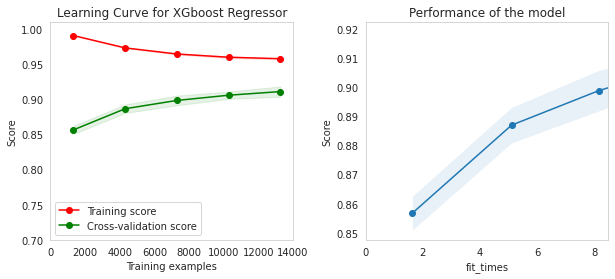

In [ ]:
title = "Learning Curve for XGboost Regressor"
plot_learning_curve(
    model_xg.best_estimator_, title, X_train_transformed,np.ravel(y_train),
     ylim=(0.7, 1.01), cv=5, n_jobs=4
);

The learning curves show that the model performed really well.

#<font color='blue'>Feature Importance</font>

In [ ]:
# creating a mapper to show the feature names on the importance plot by weight.
from xgboost import plot_importance
f_imp=model_xg.best_estimator_.get_booster().get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
mapped = {mapper[k]: v for k, v in f_imp.items()}
mapped

{'National Holiday_0': 378,
 'National Holiday_1': 112,
 'family_BEVERAGES': 306,
 'family_CLEANING': 126,
 'family_DAIRY': 159,
 'family_DELI': 180,
 'family_GROCERY I': 357,
 'family_OTHERS': 162,
 'family_PRODUCE': 182,
 'oil_price': 2901,
 'promo': 3472,
 'type_A': 534,
 'type_B': 161,
 'type_C': 201,
 'type_D': 275,
 'type_E': 220}

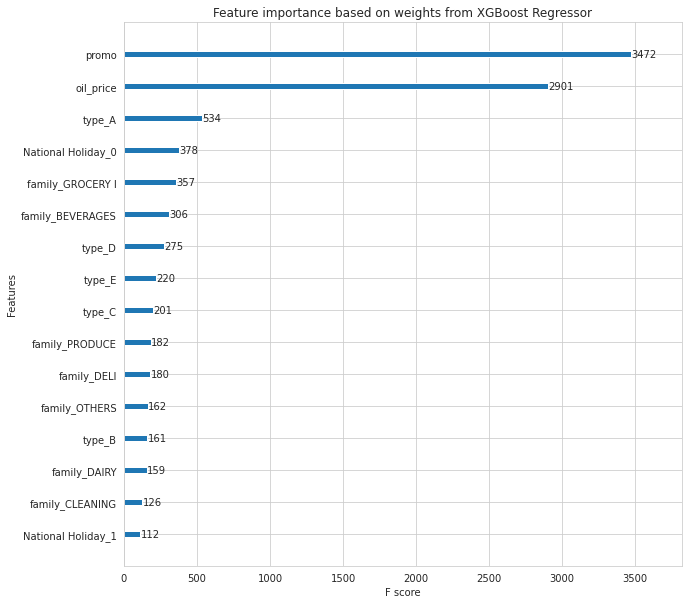

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(mapped, ax=ax,title='Feature importance based on weights from XGBoost Regressor');

The importance plot shows that the maximum weights were given to Promos, oil prices, type A stores and family grocery-1. Type A stores in terms of sales were maximum in the states of Pichincha and Guayas.

In [ ]:
f_imp_G=model_xg.best_estimator_.get_booster().get_score(importance_type='gain')
mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
mapped = {mapper[k]: v for k, v in f_imp_G.items()}
mapped

{'National Holiday_0': 184294064.42988333,
 'National Holiday_1': 187889193.5455804,
 'family_BEVERAGES': 2106051492.9577353,
 'family_CLEANING': 7730609919.88706,
 'family_DAIRY': 6081764341.412107,
 'family_DELI': 6873317858.542121,
 'family_GROCERY I': 7661894791.986419,
 'family_OTHERS': 1939699431.819015,
 'family_PRODUCE': 3338391437.9817967,
 'oil_price': 224823167.93233126,
 'promo': 605958884.1353006,
 'type_A': 2627128955.8196263,
 'type_B': 2088933116.3738146,
 'type_C': 2376659201.7753234,
 'type_D': 4991109545.10543,
 'type_E': 8406573718.759781}

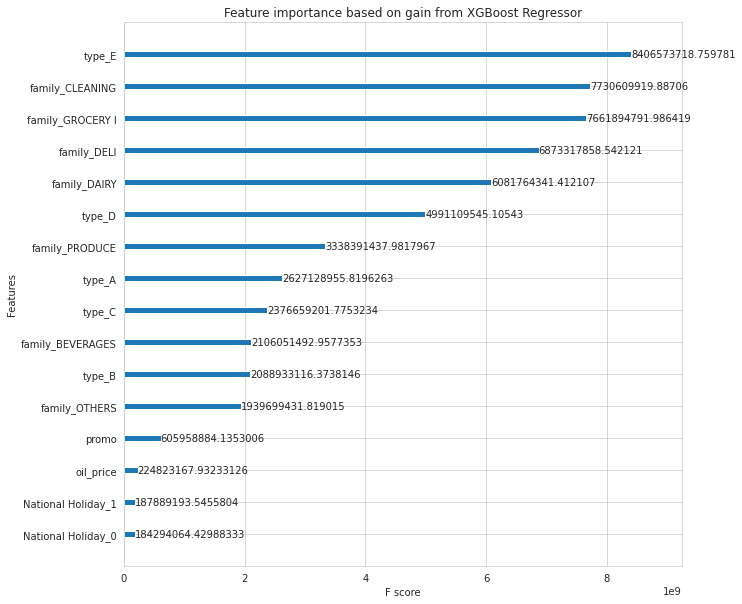

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(mapped, ax=ax,title='Feature importance based on gain from XGBoost Regressor');

#<font color='blue'>Forecasting Sales for 16th Aug 2017 - 31 Aug 2017</font>

## <font color='blue'>Auto Correlation plots of sales to see if sales from the lag can be used to predict sales in future</font>

In [ ]:
#creating a dataframe for forecast
df_forecast=df_new.groupby('date')[['sales']].sum()
df_forecast

,sales
date,
2016-01-01,1.643339e+04
2016-01-02,1.066677e+06
2016-01-03,1.226736e+06
2016-01-04,9.559569e+05
2016-01-05,8.353204e+05
...,...
2017-08-11,8.263737e+05
2017-08-12,7.926305e+05
2017-08-13,8.656397e+05


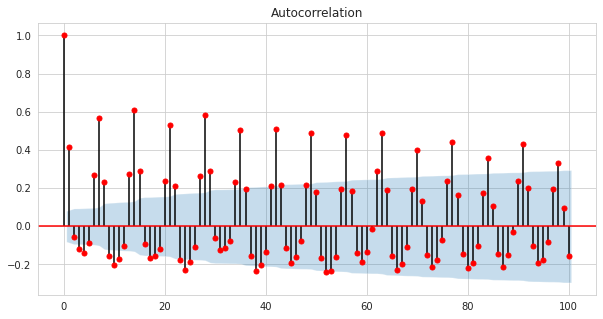

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df_forecast['sales'], ax=ax,lags=100,color='red')
plt.show()

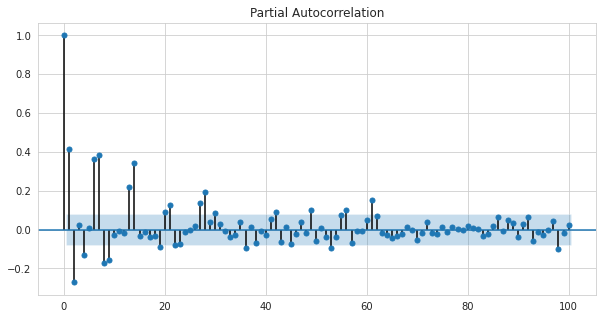

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df_forecast['sales'], ax=ax,lags=100)
plt.show()

The Autocorrelation study indicates that knowing the sales in the previous week, can be useful in predicting the sales of the upcoming weeks.

In [ ]:
#Preparing the test dataset for sales forecast
df_test=test.copy()

In [ ]:
df_test=df_test.rename(columns={'dcoilwtico':'oil_price',
                                'onpromotion':'promo'})
df_test=df_test.set_index('date')

In [ ]:
df_test.loc[~df_test['family'].isin(family_values),'family']='OTHERS'

In [ ]:
df_test

,store_nbr,family,promo,city,state,type,cluster,oil_price,National Holiday,Regional Holiday,Local Holiday
date,,,,,,,,,,,
2017-08-16,1,OTHERS,0,Quito,Pichincha,D,13,46.80,0,0,0
2017-08-16,42,OTHERS,0,Cuenca,Azuay,D,2,46.80,0,0,0
2017-08-16,42,OTHERS,12,Cuenca,Azuay,D,2,46.80,0,0,0
2017-08-16,42,OTHERS,0,Cuenca,Azuay,D,2,46.80,0,0,0
2017-08-16,42,BEVERAGES,19,Cuenca,Azuay,D,2,46.80,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,25,OTHERS,0,Salinas,Santa Elena,D,1,47.26,0,0,0
2017-08-31,25,OTHERS,6,Salinas,Santa Elena,D,1,47.26,0,0,0
2017-08-31,25,OTHERS,1,Salinas,Santa Elena,D,1,47.26,0,0,0


In [ ]:
df_test=df_test.loc[:,categorical_vars+discrete_vars+continous_vars]
df_test

,family,type,National Holiday,promo,oil_price
date,,,,,
2017-08-16,OTHERS,D,0,0,46.80
2017-08-16,OTHERS,D,0,0,46.80
2017-08-16,OTHERS,D,0,12,46.80
2017-08-16,OTHERS,D,0,0,46.80
2017-08-16,BEVERAGES,D,0,19,46.80
...,...,...,...,...,...
2017-08-31,OTHERS,D,0,0,47.26
2017-08-31,OTHERS,D,0,6,47.26
2017-08-31,OTHERS,D,0,1,47.26


In [ ]:
df1_test=df_test.groupby(['date','National Holiday','family','type'], as_index=False).agg(promo=('promo','sum'),
                                                                 oil_price=('oil_price','min'))

In [ ]:
df1_test

,National Holiday,family,type,promo,oil_price
0,0,BEVERAGES,A,199,46.80
1,0,BEVERAGES,B,353,46.80
2,0,BEVERAGES,C,582,46.80
3,0,BEVERAGES,D,397,46.80
4,0,BEVERAGES,E,175,46.80
...,...,...,...,...,...
555,0,PRODUCE,A,24,47.26
556,0,PRODUCE,B,11,47.26
557,0,PRODUCE,C,113,47.26
558,0,PRODUCE,D,28,47.26


In [ ]:
# using pipeline from above, applying transformations on the test dataset
X_test_transform_forecast = pipe_full.transform(df1_test)

In [ ]:
# predicting (forecasting) sales using the best estimator of the xgboost model
y_forecast = model_xg.best_estimator_.predict(X_test_transform_forecast) 
y_forecast.shape

(560,)

In [ ]:
#Aggregating the test dataset the same way as X_train
df1_test_forecast=df_test.groupby(['date','National Holiday','family','type']).agg(promo=('promo','sum'),
                                                                 oil_price=('oil_price','min'))

In [ ]:
# Adding a column of forecasted sales to the aggregated test dataset
df1_test_forecast['forecasted_sales']=y_forecast
df1_test_forecast #dataframe of test set (from 16th Aug,2017 till 31st Aug,2017)

promo  oil_price  forecasted_sales
date       National Holiday family    type                                    
2017-08-16 0                BEVERAGES A       199      46.80      57562.000000
                                      B       353      46.80      28051.359375
                                      C       582      46.80      28771.625000
                                      D       397      46.80      56484.707031
                                      E       175      46.80      14468.470703
...                                           ...        ...               ...
2017-08-31 0                PRODUCE   A        24      47.26      40273.769531
                                      B        11      47.26       7074.558594
                                      C       113      47.26       8057.056152
                                      D        28      47.26      46533.015625
                                      E         5      47.26       2798.324951

[560 rows x 3 columns]

In [ ]:
#dataframe on which the model was trained (from 2016 till 15th Aug 2017). Recreated it with time as index)
df_before_forecast=df_new.groupby(['date','National Holiday','family','type']).agg(total_sale=('sales','sum'),
                                                                 promo=('onpromotion','sum'),
                                                                 oil_price=('oil price','min'))
df_before_forecast

total_sale  promo  oil_price
date       National Holiday family    type                              
2016-01-01 1                BEVERAGES A          0.000      0      36.81
                                      B          0.000      0      36.81
                                      C          0.000      0      36.81
                                      D       5104.000      1      36.81
                                      E          0.000      0      36.81
...                                                ...    ...        ...
2017-08-15 0                PRODUCE   A      38131.831     82      47.57
                                      B      17984.812   1082      47.57
                                      C      14765.070   1319      47.57
                                      D      43730.397    122      47.57
                                      E      10496.861    564      47.57

[20720 rows x 3 columns]

In [ ]:
#plotting both time series, blue is (2016-01-01 till 2017-08-15), Red is (2017-08-16 till 2017-08-31)
fig1=go.Figure(data=go.Scatter(x=df_before_forecast.index.get_level_values('date'),
                               y=df_before_forecast['total_sale'],name='train'))
fig1.update_xaxes(title='Sales Forecast')
fig1.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig1.add_trace(go.Scatter(x=df1_test_forecast.index.get_level_values('date'),
                          y=df1_test_forecast['forecasted_sales'],name='forcasted Sale'))

fig1.show()
